### Descripción del problema

El dataset "Estimation of Obesity Levels Based On Eating Habits and Physical Condition" contiene datos de individuos de México, Perú y Colombia, con atributos relacionados a hábitos alimenticios, condición física y estilo de vida. El objetivo es predecir el nivel de obesidad de una persona, clasificado en siete categorías: Insufficient Weight, Normal Weight, Overweight I/II, Obesity I/II/III.

### Propuesta de valor

Desarrollar un modelo de clasificación que permita identificar el nivel de obesidad de un individuo a partir de sus hábitos y características físicas. Esto puede ser útil para sistemas de recomendación, monitoreo de salud preventiva y campañas de concientización.

### Herramienta de documentación

Se recomienda usar [MLCanvas](https://mlcanvas.com) para mapear los requerimientos, stakeholders, métricas de éxito y propuesta de solución.

In [1]:
#Sección 1: Instalación de librerías
%pip install -q "dvc[gdrive]" scikit-learn mlflow seaborn pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import os as os
import mlflow
from mlflow.tracking import MlflowClient

# Crear carpeta MLOPS en Google Drive
#!mkdir -p /content/drive/MyDrive/MLOPS

Note: you may need to restart the kernel to use updated packages.


In [2]:
client = MlflowClient()

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("MLOPSFASE1-EDA")  # se crea si no existe

#mlflow.start_run()


print("Tracking:", client._tracking_client.tracking_uri)
print("Registry:", mlflow.get_registry_uri())


#python -m mlflow ui --backend-store-uri file:///C:/Users/danie/MLOpsFase1/notebooks/mlruns --port 5000 -----Cambia la ruta a tu entorno local y ejecuta esta linea en una terminal


Tracking: file:///c:/Users/danie/MLOpsFase1/notebooks/mlruns
Registry: http://127.0.0.1:5000


In [3]:
#Sección 2: Carga y exploración inicial
df = pd.read_csv('../src/mlops/data/obesity_estimation_modified.csv')

# Forzar numéricos
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Height'] = pd.to_numeric(df['Height'], errors='coerce')
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')

# Vista general
print("Información inicial del dataset:")
print(df.info())
display(df.head())
display(df.describe(include=np.number))

Información inicial del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2135 non-null   object 
 1   Age                             2119 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2127 non-null   float64
 4   family_history_with_overweight  2133 non-null   object 
 5   FAVC                            2137 non-null   object 
 6   FCVC                            2136 non-null   object 
 7   NCP                             2129 non-null   object 
 8   CAEC                            2131 non-null   object 
 9   SMOKE                           2134 non-null   object 
 10  CH2O                            2124 non-null   object 
 11  SCC                             2138 non-null   object 
 12  F

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,mixed_type_col
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,NO,Public_Transportation,Normal_Weight,bad
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,nORMAL_wEIGHT,NaN
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,208
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,oVERWEIGHT_lEVEL_i,585
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,200


,Age,Height,Weight
count,2119.000000,2111.000000,2127.000000
mean,32.080940,4.655255,106.538946
std,102.375556,38.399377,300.509499
min,14.000000,1.450000,39.000000
25%,20.000000,1.630368,66.000000
50%,22.851773,1.703584,83.325800
75%,26.000000,1.771827,108.355733
max,2220.274371,827.641784,6408.000000


In [4]:
#Sección 3: Limpieza de datos
# Estandarizar nombres
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Normalizar categorías
for col in ['nobeyesdad', 'calc', 'caec', 'mtrans']:
    df[col] = df[col].str.strip().str.replace(' ', '_').str.lower()

# Valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Eliminar registros inválidos
df.dropna(inplace=True)


Valores nulos por columna:
gender                             18
age                                34
height                             42
weight                             26
family_history_with_overweight     20
favc                               16
fcvc                               17
ncp                                24
caec                               22
smoke                              19
ch2o                               29
scc                                15
faf                                29
tue                                33
calc                               23
mtrans                             23
nobeyesdad                         20
mixed_type_col                    241
dtype: int64


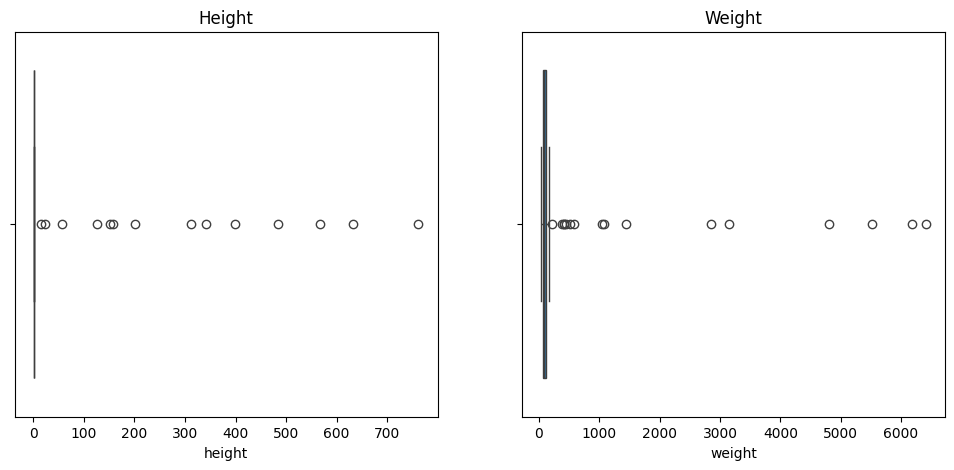


Shape final después de limpiar outliers: (1539, 18)


In [5]:
#Sección 4: Manejo de outliers
# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='height', data=df, ax=axes[0]).set_title('Height')
sns.boxplot(x='weight', data=df, ax=axes[1]).set_title('Weight')
plt.show()

# Filtrado por IQR
for col in ['height', 'weight']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("\nShape final después de limpiar outliers:", df.shape)

In [6]:
#Eliminar registros con edad menor a 0 y amyor a 100
df = df[(df['age'] >= 0) & (df['age'] <= 100)]

In [7]:
#Sección 5: Preprocesamiento

# Codificación de variables categóricas
label_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Normalización
scaler = StandardScaler()
df[['age', 'height', 'weight']] = scaler.fit_transform(df[['age', 'height', 'weight']])

# Separar features y target
X = df.drop('nobeyesdad', axis=1)
y = df['nobeyesdad']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Sección 6: Guardar dataset limpio
df.to_csv('../src/mlops/data/obesity_estimation_cleaned.csv', index=False)

print("✅ Dataset limpio guardado como obesity_estimation_cleaned.csv")

✅ Dataset limpio guardado como obesity_estimation_cleaned.csv


In [ ]:
#Sección 7: Versionado con Git y DVC
# Inicializar Git y DVC
# !git init
# !dvc init

# Añadir dataset limpio
#!dvc add obesity_estimation_cleaned.csv

# Configurar identidad
# !git config --global user.email "git email here"
# !git config --global user.name "git user name "

# Añadir archivos al commit
# !git add obesity_estimation_cleaned.csv.dvc .gitignore .dvc
# !git add -m "Agrego codigo en paso 7 para eliminar outliers or edad > 100 y < 0"

# Conectar con GitHub
# !git branch -M main
# !git remote add origin https://github.com/JCGarcesDC/MLOpsFase1.git


# Fusionar cambios remotos si existen
# !git pull origin main --allow-unrelated-histories

# Subir a GitHub
# !git push -u origin main

In [ ]:
#!git remote --v

In [ ]:
# Configurar estrategia de merge por defecto
#!git config pull.rebase false

# Hacer pull para traer los cambios remotos y fusionarlos
#!git pull origin main --allow-unrelated-histories

# Añadir archivos al commit
#!git add obesity_estimation_cleaned.csv.dvc .gitignore .dvc

# Hacer commit
#!git commit -m "Sincronizar cambios locales con rama remota"

# Subir a GitHub
#!git push -u origin main

🔍 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           2       0.78      0.89      0.83        36
           3       0.97      0.96      0.96        67
           4       0.98      0.98      0.98        46
           5       1.00      1.00      1.00        41
           6       0.88      0.83      0.85        35
           7       0.95      0.93      0.94        43

    accuracy                           0.94       305
   macro avg       0.93      0.93      0.93       305
weighted avg       0.94      0.94      0.94       305



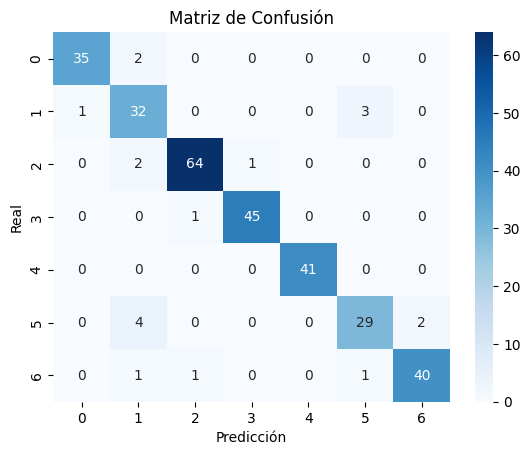

In [9]:
#Sección 8: Construcción y evaluación de modelos
# Modelo base: Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación
print("🔍 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [10]:
#Sección 9: Ajuste de hiperparámetros
params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

#Logeo de los parametros en mlflow
mlflow.log_params(params)

grid = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("✅ Mejor modelo:", grid.best_params_)
print("🔍 Mejor score:", grid.best_score_)

c:\Users\danie\anaconda3\envs\env-pyspark\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


✅ Mejor modelo: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
🔍 Mejor score: 0.9409451995658893


### Roles del equipo

- **Juan Carlos Garcés (JCGarcesDC)**: Responsable de limpieza de datos, configuración de DVC y GitHub, y entrenamiento de modelos.
- **Daniel Olivares - A01796061**: Colabora don la parte de limpieza de datos e implementacion  de mlflow, asi como logeo de parametros
- **Integrantes adicionales**: Documentar sus contribuciones en el repositorio (EDA, visualizaciones, ajuste de modelos, documentación en MLCanvas).

